# Variational Quantum Eigensolver through Bayesian Optimisation using Observables
### Estimation of ground state energy, Hamiltonian $H_{4}= X_{0}Z_{1}X_{2} + X_{0}Z_{2}X_{3} + Z_{0}X_{2}+ X_{1}Z_{3}$

In [1]:
#Import libraries
import torch
from matplotlib import pyplot as plt
from qiskit import QuantumCircuit
import numpy as np
from math import pi
import matplotlib.pylab as plt
from itertools import product
from qiskit.quantum_info import Operator
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.insert(1, '../src/')
from utils.functions import *
from models.models_bo import *

from qiskit.quantum_info import SparsePauliOp


In this cell, we define the quantum circuit designed to estimate the ground state energy. You can also modify the Hamiltonian and the initial state directly within this cell, allowing for flexibility in the setup. <br />

Each observable of the Hamiltonian is represented with a surrogate model

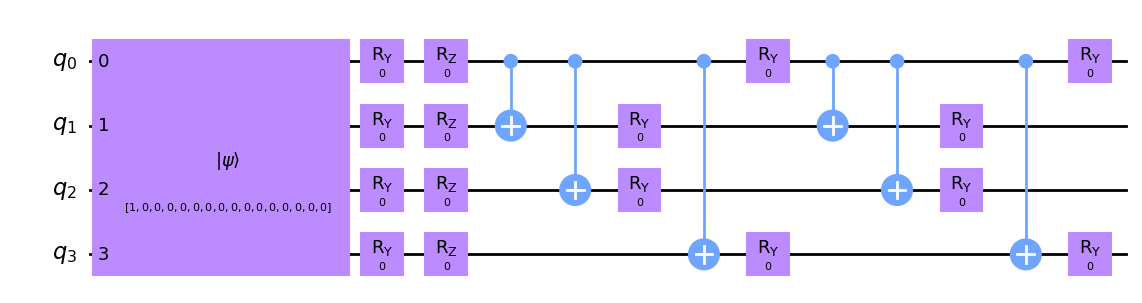

In [2]:
#Define the circuit
def create_circuit_VQE4(thetas, initial_state):
    circ = QuantumCircuit(4)
    # Define parameters for rotation gates
    circ.initialize(initial_state, [0,1,2,3])
    
    # Apply parameterized rotation gates
    circ.ry(thetas[0,0], 0)
    circ.ry(thetas[0,1], 1)
    circ.ry(thetas[0,2], 2)
    circ.ry(thetas[0,3], 3)
    
    circ.rz(thetas[0,4], 0)
    circ.rz(thetas[0,5], 1)
    circ.rz(thetas[0,6], 2)
    circ.rz(thetas[0,7], 3)
    
    # Apply entangling gates
    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.cx(0, 3)
    
    circ.ry(thetas[0,8], 0)
    circ.ry(thetas[0,9], 1)
    circ.ry(thetas[0,10], 2)
    circ.ry(thetas[0,11], 3)
   
    circ.cx(0, 1)
    circ.cx(0, 2)
    circ.cx(0, 3)

    circ.ry(thetas[0,12], 0)
    circ.ry(thetas[0,13], 1)
    circ.ry(thetas[0,14], 2)
    circ.ry(thetas[0,15], 3)

    return circ


#Define the number of parameters and qubits
n_thetas = 16 #Number of parameters
num_qubits = 4

thetas = np.random.rand(n_thetas)
initial_state = np.zeros(2**num_qubits)
initial_state[0] = 1

#Define the Hamiltonian
H = (SparsePauliOp.from_list([
    ('XZXI', 1.0),
    ('XIZX', 1.0),
    ('ZIXI', 1.0),
    ('IXIZ', 1.0)
]))


circ_visualization = create_circuit_VQE4(np.zeros(n_thetas)[np.newaxis,:],initial_state)
circ_visualization.draw('mpl')

In [3]:
circuit = create_circuit_VQE4

n_surrogates_models = len(H.coeffs)

#If you want to estimate the performance with a set of test of the surrogate models, it is recommended to use the lines that contain the word "test"
#they are commented to reduce the computational cost.
#n_test_samples = 100
#X_test, y_test_expectation_values, y_test_sum_expectation_values = get_real_samples_vqe(circuit, n_test_samples, n_thetas, initial_state, H, type_sampling = 'Random_Uniform')


Main parameters of the BO

In [4]:
#Generate initial samples
n_initial_samples = 100
#Number of time to run the BO
n_run = 1

#Number of iterations of one BO
n_BO = 100

#Parameter of the function of adquisicion
beta = 1

In [5]:
#BO loop

n_BO +=1
#Percentage of data to keep to train the degenerated GP. 0.1->10%  of the new 
history_best_eigenvalue_runs = np.zeros((n_run,n_BO))
best_eigenvalue_runs = np.zeros(n_run)
best_thetas_runs = np.zeros((n_run, n_thetas))

n_samples_acquisition_fx = 1000
#Parameters of the GPs
params = {'training_iter': 10, 'learning_rate':0.1, 'initial_noise':1e-8, 'initial_lengthscale':0.9, 'initial_output_scale': 1, 'scaler_target': None, #'StandardScaler',
                'verbose':False }
bounds = torch.stack([torch.zeros(n_thetas), 2*pi*torch.ones(n_thetas)])  #Bounds angles  


for iter_run in range(n_run):
    print('run ', iter_run+1)
    X_initial_thetas, y_initial_expectation_values, y_initial_eigenvalues = get_real_samples_vqe(circuit, n_initial_samples, n_thetas, initial_state, H, type_sampling = 'LHS')


    history_best_eigenvalue = []
    keys = (['mean_MSE_eigenvalue_train', 'mean_MSE_eigenvalue_test'] +
            ['mean_loss_train_sm_'+str(n_sm) for n_sm in range(n_surrogates_models)]+
            ['mean_loss_test_sm_'+str(n_sm) for n_sm in range(n_surrogates_models)])
    mean_metrics = {key: np.zeros(n_BO) for key in keys}

    history_thetas = np.zeros((n_BO,n_thetas))

    #Store real data
    X_train, y_train_expectations_values, y_train_eigenvalues = X_initial_thetas, y_initial_expectation_values, y_initial_eigenvalues

    #train model and save variables of training
    surrogate_models, metrics_models = {'gp_model':[], 'likelihood':[], 'scaler_target':[]}, {}
    for n_sm in range(n_surrogates_models):
        gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_expectations_values[:,n_sm], [], [], params))
        #gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_eigenvalues, [], [], params))
        surrogate_models['gp_model'].append(gp_model)
        surrogate_models['likelihood'].append(ll)
        surrogate_models['scaler_target'].append(scaler_y)
        metrics_models['model_train_'+str(n_sm)] = metrics['loss_train'][-1]
        #metrics_models['model_test_'+str(n_sm)] = metrics['loss_test'][-1]


    #Best eigenvalue
    idx_best_eigenvalue = np.argmax(y_initial_eigenvalues)
    best_eigenvalue = y_train_eigenvalues[idx_best_eigenvalue]
    best_thetas = X_train[idx_best_eigenvalue]
    history_best_eigenvalue.append(-best_eigenvalue)


    mean_estimated_eigenvalues_train,std_estimated_eigenvalues_train = get_eigenvalues_from_expectations_values(surrogate_models, X_train, np.ones(n_surrogates_models), num_qubits)  
    #mean_estimated_eigenvalues_test,std_estimated_eigenvalues_test = get_eigenvalues_from_expectations_values(surrogate_models, X_test, np.ones(n_surrogates_models), num_qubits)  
    iter_BO = 0
    mean_metrics['mean_MSE_eigenvalue_train'][iter_BO] = np.mean((mean_estimated_eigenvalues_train - y_train_eigenvalues)**2)
    #mean_metrics['mean_MSE_fidelity_test'][iter_BO] = np.mean((mean_estimated_fidelities_test - y_test_fidelities)**2)
    for n_sm in range(n_surrogates_models):
        mean_metrics['mean_loss_train_sm_'+str(n_sm)][iter_BO] = metrics_models['model_train_'+str(n_sm)]
        #mean_metrics['mean_loss_test_sm_'+str(n_sm)][iter_BO] = metrics_models['model_test_'+str(n_sm)]



    pbar = tqdm(range(1, n_BO))
    for iter_BO in pbar:
        # Generate new angles samples
        wrapped_gp_model = WrappedGPyTorchModelMultiGPHamiltonian(surrogate_models, np.ones(n_surrogates_models), num_qubits)
        #wrapped_gp_model = WrappedGPyTorchModelMonoGP(gp_model)

        fx_acq = UpperConfidenceBound(wrapped_gp_model, beta = beta)
        fx_acq.model.eval()

        candidate, acq_value = optimize_acqf(
            acq_function=fx_acq,
            bounds=bounds,
            q=1,
            num_restarts=5,
            raw_samples=n_samples_acquisition_fx,
        )
        
        new_sample = np.array(candidate).squeeze(0)

        new_exp_values, new_eigenvalue = get_expectation_values_hamiltonian(circuit, new_sample[np.newaxis,:], initial_state, H)

        #Add new data to known X_theta, y_real_expectation_values and y_real_fidelity
        X_train = np.vstack((X_train,new_sample[np.newaxis,:]))
        y_train_eigenvalues = np.hstack((y_train_eigenvalues, new_eigenvalue))
        y_train_expectations_values = np.vstack((y_train_expectations_values, new_exp_values))

        #Check if the new eigenvalue is best than the current best eigenvalue
        if new_eigenvalue>best_eigenvalue:
            best_eigenvalue = new_eigenvalue
            best_thetas = new_sample
            
        history_best_eigenvalue.append(-best_eigenvalue)
        history_thetas[iter_BO] = -best_thetas

        #Update the models
        surrogate_models, metrics_models = {'gp_model':[], 'likelihood':[], 'scaler_target':[]}, {}

        for n_sm in range(n_surrogates_models):
            gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_expectations_values[:,n_sm], [], [], params))
            #gp_model, ll, metrics, scaler_y = train_surrogate_models_gp((X_train, y_train_eigenvalues, [], [], params))

            surrogate_models['gp_model'].append(gp_model)
            surrogate_models['likelihood'].append(ll)
            surrogate_models['scaler_target'].append(scaler_y)
            metrics_models['model_train_'+str(n_sm)] = metrics['loss_train'][-1]
            #metrics_models['model_test_'+str(n_sm)] = metrics['loss_test'][-1]
        
        
        mean_estimated_eigenvalues_train, std_estimated_eigenvalues_train = get_eigenvalues_from_expectations_values(surrogate_models, X_train, np.ones(n_surrogates_models), num_qubits)  
        #mean_estimated_eigenvalues_test, std_estimated_eigenvalues_test = get_eigenvalues_from_expectations_values(surrogate_models, X_test, np.ones(n_surrogates_models), num_qubits)  
        mean_metrics['mean_MSE_eigenvalue_train'][iter_BO] = np.mean((mean_estimated_eigenvalues_train - y_train_eigenvalues)**2)
        #mean_metrics['mean_MSE_fidelity_test'][iter_BO] = np.mean((mean_estimated_fidelities_test - y_test_fidelities)**2)
        for n_sm in range(n_surrogates_models):
            mean_metrics['mean_loss_train_sm_'+str(n_sm)][iter_BO] = metrics_models['model_train_'+str(n_sm)]
            #mean_metrics['mean_loss_test_sm_'+str(n_sm)][iter_BO] = metrics_models['model_test_'+str(n_sm)]


        pbar.set_description('Current best eigenvalue {}'.format(np.round(-best_eigenvalue, 9)))


    history_best_eigenvalue_runs[iter_run] = history_best_eigenvalue
    best_eigenvalue_runs[iter_run] = -best_eigenvalue
    best_thetas_runs[iter_run] = -best_thetas




run  1


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
#Get true ground state energy
from scipy.linalg import eigh

eigenvalues, eigenvectors = eigh(H.to_matrix())
ground_state_energy = np.min(eigenvalues)
ground_state = eigenvectors[:, np.argmin(eigenvalues)]

print(f"Ground state energy: {ground_state_energy}")
print(f"Ground state:\n{ground_state}")



In [ ]:
fig, ax = plt.subplots(2,1,figsize=(10,7), facecolor='white', constrained_layout = True, sharex=False, sharey=False)

plt.suptitle('Eigenvalues during Bayesian Optimisation')

ax[0].set_title(r'Hamiltonian: $X_{0}Z_{1}X_{2} + X_{0}Z_{2}X_{3} + Z_{0}X_{2}+ X_{1}Z_{3}$')
ax[0].plot(np.arange(n_BO), np.mean(history_best_eigenvalue_runs,0), '-o', linewidth=1.3, color='k', markersize=2.5, label = 'BO Eigenvalue')
ax[0].axhline(ground_state_energy, linestyle='--',color='r', label='Ground state energy $E_{0}$')

ax[1].plot(np.arange(n_BO), np.mean(history_best_eigenvalue_runs,0) - ground_state_energy, '-o', linewidth=1.3, color='k', markersize=2.5, label = 'Eigenvalue - $E_{0}$')

ax[1].set_yscale('log')
ax[0].set_ylabel('Eigenvalue')
ax[1].set_ylabel('Eigenvalue - $E_{0}$')
ax[1].set_xlabel('Number of iterations')

ax[0].legend(loc='upper right')
ax[1].legend(loc='upper right')

plt.legend()
plt.show()

In [ ]:
#Save data generated
data_plot = {   'history_best_eigenvalue_runs':history_best_eigenvalue_runs,
                'best_thetas_runs': best_thetas_runs,
                'best_eigenvalue_runs':best_eigenvalue_runs, 
                'history_best_fidelity':history_best_eigenvalue, 
                'best_thetas':best_thetas,
                'best_eigenvalue': best_eigenvalue, 
                'n_samples_acquisition_fx':n_samples_acquisition_fx,
                'n_BO': n_BO,
                'learning_rate': params['learning_rate'],
                'initial_noise': params['initial_noise'],
                'scaler_target': params['scaler_target'],
                'n_initial_samples': n_initial_samples,
                'mean_MSE_eigenvalue_train':mean_metrics['mean_MSE_eigenvalue_train'],
                'mean_MSE_eigenvalue_test':mean_metrics['mean_MSE_eigenvalue_test'],
                'real_ground_state_energy':ground_state_energy,
                'type_acq_function': str(fx_acq),
                'H_matrix':H.to_matrix(),
                'H_coeffs':H.coeffs,
                 
             }


if True:
    with open("../results/vqe/results_hamiltonian_"+ str(num_qubits)+"qubits.json", "w") as outfile: 
        json.dump(data_plot, outfile, cls=CustomEncoder)
    